# A Masked Language Model for Project CodeNet

> Copyright (c) 2021 International Business Machines Corporation  
Prepared by [Geert Janssen](geert@us.ibm.com>)

## Introduction

This experiment investigates whether a popular attention model to
construct a masked language model (MLM) can be used for source code
instead of natural language sentences. We here closely follow the
approach by Ankur Singh documented in his
[blog](https://keras.io/examples/nlp/masked_language_modeling).

The goal of the model is to be able to infer the correct token for a
masked-out token at an arbitrary position in the source text.
We will use the special token literal `[mask]` to represent the masked
out token. We assume that in the training and test sets precisely one token
is randomly masked per sample. The original token at that position is
then the golden label, or ground truth.

In [1]:
#@title Imports
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras import Sequential, Model, losses, metrics, optimizers
from tensorflow.keras import callbacks
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization
from tensorflow.keras.layers import Dense, Dropout, Input, Embedding
from dataclasses import dataclass
import pandas as pd
import numpy as np
import glob
import random
import tarfile
import requests
import os
import shutil

## Dataset

The Project CodeNet dataset consist of a large collection (close to 14 million) of
submissions in various programming languages to problems posed on
online judging sites. The submissions are typically small, complete
programs in a single source file. There are 1000s of problems in this dataset.

We extract a selection of C programming language files from the
Project CodeNet dataset for training and evaluation:

| Aspect              | Value |
| ------------------- | ----- |
| purpose             | training |
| submission status   | Accepted |
| smallest size       | 200 bytes |
| largest size        | 500 bytes |
| samples per problem | at most 100 |
| problems            | 0-3417 |
| total samples       | 50,000 |

Notice that the training and evaluation are derived from
non-overlapping sets of problems. It might also be interesting to see
what happens when a different split is made, e.g. by selecting 110
submissions from each problem and using 100 for training and the rest for evaluation.

| Aspect              | Value |
| ------------------- |------ |
| purpose             | evaluation |
| submission status   | Accepted |
| smallest size       | 200 bytes |
| largest size        | 500 bytes |
| samples per problem | at most 100 |
| problems            | 3418-3636 |
| total samples       | 5,000 |

In [2]:
# Download the subset of the Project CodeNet data described above.
file_name = "Project_CodeNet_MLM.tar.gz"
data_url = f"https://dax-cdn.cdn.appdomain.cloud/dax-project-codenet/1.0.0/{file_name}"

# Download tar archive to local disk
if os.path.exists(file_name):
    os.remove(file_name) 
with open(file_name, "wb") as f:
    f.write(requests.get(data_url).content)
    
# Extract contents of archive to local disk
if os.path.exists("tokens"):
    shutil.rmtree("tokens")    
with tarfile.open(file_name) as f:
    f.extractall()

## Data preparation

Each C file is tokenized into a vocabulary of 414 distinct tokens:

| Type           | Count | Description |
| -------------- | ----: | -- |
|the keyword     |    95 | all C++20 reserved words |
|the function    |   279 | function names in common header files |
|the identifier  |    18 | standard identifiers, like stderr, etc. |
|the punctuator  |    15 | small set of punctuation symbols |
|# or ##         |     2 | the 2 C preprocessor symbols |
|the token class |     5 | one of: id, number, operator, character, string |

By _the keyword_, _the function_ and so on, we mean the actual keyword
or function literal, like `while` for a keyword and `strlen` for a function.
The tokens are output on a single line separated by spaces.
It turns out that our training set overall uses some 200 out of the 414
possible tokens; not all keywords and standard functions are used presumably.

This code snippet:
```C
for (i = 0; i < strlen(s); i++) {}
```

will be converted to:
```C
for ( id = number ; id < strlen ( id ) ; id operator ) { }
```

The tokenized source files are read into a pandas dataframe and
processed by the Keras `TextVectorization` layer to extract a vocabulary
and encode all token lines into vocabulary indices. Index 0 is
reserved for padding; index 1 is the `<UNK>` value for Out-Of-Vocabulary
tokens (not used in our case since the input vocabulary is of fixed
size); the last index (least frequent position) is dedicated to encode
the special `[mask]` token. Each sample will have a fixed token length
of 256. The average number of tokens per sample across the training
set is 131. Short samples are padded with 0 and too large ones are
simply truncated. The same operations will be applied to the test set.

In [3]:
# Read all files and return content as list of lines.
def get_text_list_from_files(files):
    text_list = []
    for name in files:
        with open(name) as f:
            for line in f:
                text_list.append(line)
    return text_list

# Compose the full path names to the token files.
# Creates and returns a dataframe with single key "tokens".
def get_data_from_text_files(folder_name):
    files = glob.glob(folder_name + '/*.toks')
    texts = get_text_list_from_files(files)
    df = pd.DataFrame({'tokens': texts})
    df = df.sample(len(df)).reset_index(drop=True)
    return df

train_data = get_data_from_text_files('tokens/train')
print(train_data.head())

                                              tokens
0  # include < id . id > # include < id . id > in...
1  # include < id . id > int main ( void ) { int ...
2  # include < id . id > # include < id . id > in...
3  # include < id . id > int id ( int id , int id...
4  long long id [ number ] [ number ] , id , id ;...


Let's collect all configuration parameters in a one place:

In [4]:
@dataclass
class Config:
    MAX_LEN = 256               # length of each input sample in tokens
    BATCH_SIZE = 32             # batch size
    LR = 0.001                  # learning rate
    VOCAB_SIZE = 256            # max. number of words in vocabulary
    EMBED_DIM = 128             # word embedding vector size
    NUM_HEAD = 8                # number of attention heads (BERT)
    FF_DIM = 128                # feedforward dimension (BERT)
    NUM_LAYERS = 1              # number of BERT module layers

config = Config()

We use the Keras TextVectorization layer to process all data and extract a vocabulary of tokens to which we add the special `[mask]` token:

In [5]:
# No special text filtering.
def custom_standardization(input_data):
    return input_data

# Create TextVectorization layer.
def get_vectorize_layer(texts, vocab_size, max_seq):
    vectorize_layer = TextVectorization(
        max_tokens=vocab_size,
        output_mode='int',
        standardize=custom_standardization,
        output_sequence_length=max_seq,
    )
    # Create vocabulary over all texts:
    vectorize_layer.adapt(texts)
    # Insert special mask token in vocabulary:
    vocab = vectorize_layer.get_vocabulary()
    vocab = vocab[2:len(vocab)-1] + ['[mask]']
    vectorize_layer.set_vocabulary(vocab)
    return vectorize_layer

vectorize_layer = get_vectorize_layer(
    train_data.tokens.values.tolist(),
    config.VOCAB_SIZE,
    config.MAX_LEN,
)

vocab = vectorize_layer.get_vocabulary()
print('vocabulary size:', len(vocab))
print('padding token vocab[0]: "%s"' % vocab[0])
print('OOV token vocab[1]: "%s"' % vocab[1])
print('mask token vocab[%d]: "%s"' % (len(vocab)-1, vocab[len(vocab)-1]))

vocabulary size: 203
padding token vocab[0]: ""
OOV token vocab[1]: "[UNK]"
mask token vocab[202]: "[mask]"


In [6]:
# Encode the token strings to int vocab indices.
def encode(texts):
    encoded_texts = vectorize_layer(texts)
    return encoded_texts.numpy()

# Get mask token id for masked language model
mask_token_id = encode(['[mask]'])[0][0]
print('mask_token_id:', mask_token_id) # (always last index in vocab)

# Randomly replace tokens by the [mask] and keep replaced token as label.
def get_masked_input_and_labels(encoded_texts):
    # These numbers come from something called the "BERT recipe":
    # 15% used for prediction. 80% of that is masked. 10% is random token,
    # 10% is just left as is.

    # 15% masking:
    inp_mask = np.random.rand(*encoded_texts.shape) < 0.15
    # Do not mask special tokens:
    inp_mask[encoded_texts < 2] = False
    # Set targets to -1 by default, it means ignore:
    labels = -1 * np.ones(encoded_texts.shape, dtype=int)
    # Set golden labels for the masked tokens:
    labels[inp_mask] = encoded_texts[inp_mask]
    # False positions -> -1, True -> encoded word (vocab index)

    # Prepare input
    encoded_texts_masked = np.copy(encoded_texts)
    # Set input to [mask] for 90% of tokens (leaving 10% unchanged):
    inp_mask_2mask = inp_mask & (np.random.rand(*encoded_texts.shape) < 0.90)
    encoded_texts_masked[inp_mask_2mask] = mask_token_id

    # Set 10% to a random token
    inp_mask_2random = inp_mask_2mask & (np.random.rand(*encoded_texts.shape) < 1 / 9)
    encoded_texts_masked[inp_mask_2random] = np.random.randint(
        2, mask_token_id, inp_mask_2random.sum())

    # Prepare sample_weights to pass to .fit() method:
    sample_weights = np.ones(encoded_texts.shape)
    sample_weights[labels == -1] = 0

    # y_labels would be same as encoded_texts, i.e., input tokens
    y_labels = np.copy(encoded_texts)

    return encoded_texts_masked, y_labels, sample_weights

# Prepare data for masked language model

# Encoding step:
x_all_tokens = encode(train_data.tokens.values)
print('x_all_tokens.shape:', x_all_tokens.shape)

# Masking step:
x_masked_train, y_masked_labels, sample_weights = get_masked_input_and_labels(
    x_all_tokens
)

mlm_ds = (
    tf.data.Dataset.from_tensor_slices(
        (x_masked_train, y_masked_labels, sample_weights))
    .shuffle(1000)
    .batch(config.BATCH_SIZE)
)

mask_token_id: 202
x_all_tokens.shape: (50000, 256)


## Model

As mentioned above, the BERT-like model is copied from the Keras
example "End-to-end Masked Language Modeling with BERT" by Ankur Singh, implemented in this [Jupyter Notebook](https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/nlp/ipynb/masked_language_modeling.ipynb).

In [7]:
def bert_module(query, key, value, i):
    # Multi headed self-attention
    att_out = MultiHeadAttention(
        num_heads=config.NUM_HEAD,
        key_dim=config.EMBED_DIM // config.NUM_HEAD,
        name='encoder_{}/multiheadattention'.format(i))(query, key, value)
    att_out = Dropout(0.1, name='encoder_{}/att_dropout'.format(i))(att_out)
    att_out = LayerNormalization(
        epsilon=1e-6,
        name='encoder_{}/att_layernormalization'.format(i))(query + att_out)

    # Feed-forward layer
    ffn = Sequential([
            Dense(config.FF_DIM, activation='relu'),
            Dense(config.EMBED_DIM)
            ], name='encoder_{}/ffn'.format(i))
    ffn_out = ffn(att_out)
    ffn_out = Dropout(0.1, name='encoder_{}/ffn_dropout'.format(i))(ffn_out)
    sequence_output = LayerNormalization(
        epsilon=1e-6,
        name='encoder_{}/ffn_layernormalization'.format(i))(att_out + ffn_out)
    return sequence_output

def get_pos_encoding_matrix(max_len, d_emb):
    pos_enc = np.array(
        [
            [pos / np.power(10000, 2 * (j // 2) / d_emb) for j in range(d_emb)]
            if pos != 0
            else np.zeros(d_emb)
            for pos in range(max_len)
        ]
    )
    # 0::2 means start at 0 and step 2 (all even)
    pos_enc[1:, 0::2] = np.sin(pos_enc[1:, 0::2])  # dim 2i
    pos_enc[1:, 1::2] = np.cos(pos_enc[1:, 1::2])  # dim 2i+1
    return pos_enc

loss_fn = losses.SparseCategoricalCrossentropy(
    reduction=losses.Reduction.NONE
    )
loss_tracker = metrics.Mean(name='loss')

class MaskedLanguageModel(Model):
    def train_step(self, inputs):
        if len(inputs) == 3:
            features, labels, sample_weight = inputs
        else:
            features, labels = inputs
            sample_weight = None

        with tf.GradientTape() as tape:
            predictions = self(features, training=True)
            loss = loss_fn(labels, predictions, sample_weight=sample_weight)

        # Compute gradients:
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights:
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Compute our own metrics:
        loss_tracker.update_state(loss, sample_weight=sample_weight)

        # Return a dict mapping metric names to current value
        return {'loss': loss_tracker.result()}

    @property
    def metrics(self):
        # We list our `Metric` objects here so that `reset_states()` can be
        # called automatically at the start of each epoch
        # or at the start of `evaluate()`.
        # If you don't implement this property, you have to call
        # `reset_states()` yourself at the time of your choosing.
        return [loss_tracker]

def create_masked_language_bert_model():
    inputs = Input((config.MAX_LEN,), dtype=tf.int64)

    word_embeddings = Embedding(
        input_dim=config.VOCAB_SIZE,
        output_dim=config.EMBED_DIM,
        name='word_embedding')(inputs)

    position_embeddings = Embedding(
        input_dim=config.MAX_LEN,
        output_dim=config.EMBED_DIM,
        weights=[get_pos_encoding_matrix(config.MAX_LEN, config.EMBED_DIM)],
        name='position_embedding',
        )(tf.range(start=0, limit=config.MAX_LEN, delta=1))

    encoder_out = word_embeddings + position_embeddings

    for i in range(config.NUM_LAYERS):
        encoder_out = bert_module(encoder_out, encoder_out, encoder_out, i)

    mlm_output = Dense(config.VOCAB_SIZE, name='mlm_cls',
                       activation='softmax')(encoder_out)
    mlm_model = MaskedLanguageModel(inputs, mlm_output,
                                    name='masked_bert_model')
    optimizer = optimizers.Adam(learning_rate=config.LR)
    mlm_model.compile(optimizer=optimizer)
    return mlm_model

mlm_model = create_masked_language_bert_model()
mlm_model.summary()

Model: "masked_bert_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256)]        0                                            
__________________________________________________________________________________________________
word_embedding (Embedding)      (None, 256, 128)     32768       input_1[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.add (TFOpLambd (None, 256, 128)     0           word_embedding[0][0]             
__________________________________________________________________________________________________
encoder_0/multiheadattention (M (None, 256, 128)     66048       tf.__operators__.add[0][0]       
                                                                 tf.__operators__.

## Training

The model is trained with 50,000 samples in batches of 32 (1563
batches per epoch) over 5 epochs with a learning rate of 0.001 using the
Adam optimizer.

Train BERT MLM model on Project CodeNet:
Epoch 1/5
1563/1563 [==============================] - 465s 297ms/step - loss: 1.9673
Epoch 2/5
1563/1563 [==============================] - 497s 318ms/step - loss: 0.7906
Epoch 3/5
1563/1563 [==============================] - 493s 316ms/step - loss: 0.5638
Epoch 4/5
1563/1563 [==============================] - 495s 317ms/step - loss: 0.4734
Epoch 5/5
1563/1563 [==============================] - 463s 296ms/step - loss: 0.4187


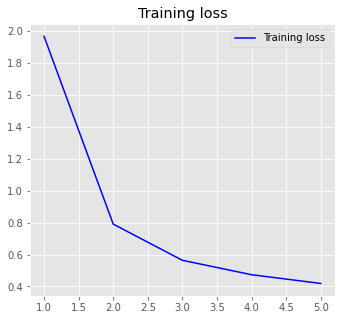

In [8]:
print('Train BERT MLM model on Project CodeNet:')
history = mlm_model.fit(mlm_ds, epochs=5)
#mlm_model.save('bert_mlm_codenet.h5')

import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    loss = history.history['loss']
    x = range(1, len(loss) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.title('Training loss')
    plt.legend()
    plt.show()

plot_history(history)

## Evaluation

We evaluate the trained model on a test set of 5,000 samples taken
from problems not considered for the training set. Each sample is
preprocessed in the same way as the training samples and one token
(never a padding!) is arbitrarily replaced by the `[mask]`. Then a
prediction is generated and the top 1 and top 5 results are compared
with the expected value. The achieved accuracies are printed in the end.


In [9]:
# Load pretrained bert model
#from tensorflow import keras
#mlm_model = keras.models.load_model('bert_mlm_codenet.h5',
#    custom_objects={'MaskedLanguageModel': MaskedLanguageModel})
mlm_model.trainable = False

# token<->id mappings as dicts:
id2token = dict(enumerate(vocab))
token2id = {y: x for x, y in id2token.items()}

# Turns text into list of vocabulary indices.
def prep(text):
    R = [0] * config.MAX_LEN # all padding
    text = text.split()
    ntoks = len(text)
    if ntoks > config.MAX_LEN:
        ntoks = config.MAX_LEN
        text = text[:ntoks]
    # pick random position (never a padding):
    k = random.randint(0, ntoks-1)
    golden = 0
    for i in range(len(text)):
        w = text[i]
        if w in token2id:
            R[i] = token2id[w]
        else:
            R[i] = 1 # OOV: [UNK]
        if i == k:
            golden = R[i]
            R[i] = mask_token_id
    return k, golden, np.array(R)

def predict(text):
    mask_index, golden, R = prep(text)
    sample = np.reshape(R, (1, config.MAX_LEN))
    prediction = mlm_model.predict(sample)
    # all substitute word probabilities:
    mask_prediction = prediction[0][mask_index]
    # word indices with top-k highest probabilities:
    top_k = 5
    top_indices = mask_prediction.argsort()[-top_k:][::-1]
    # probabilities of the top_k
    values = mask_prediction[top_indices]
    correct_top1 = top_indices[0] == golden
    correct_top5 = False
    for i in range(len(top_indices)):
        if top_indices[i] == golden:
            correct_top5 = True
            break
    return correct_top1, correct_top5

# Enumerate all test samples:
test_data = get_data_from_text_files('tokens/test')
print(test_data.head())

correct_top1 = 0
correct_top5 = 0
num_tests = 0
for test in test_data['tokens']:
    # predict and check
    top1, top5 = predict(test)
    if top1:
        correct_top1+=1
    if top5:
        correct_top5+=1
    num_tests+=1

print('number of test samples:', num_tests)
print('top-1 accuracy:', correct_top1/num_tests);
print('top-5 accuracy:', correct_top5/num_tests);

                                              tokens
0  # include < id . id > int main ( void ) { int ...
1  # include < id . id > int main ( ) { int id , ...
2  # include < id . id > int main ( ) { char id [...
3  # include < id . id > int main ( void ) { int ...
4  # include < id . id > int main ( void ) { char...
number of test samples: 5000
top-1 accuracy: 0.9248
top-5 accuracy: 0.9958


## References

> <a id="1">[1]</a>
Ankur Singh,
["End-to-end Masked Language Modeling with BERT"](https://keras.io/examples/nlp/masked_language_modeling)

> <a id="2">[2]</a>
[CodeXGLUE -- Code Completion (token level)](https://github.com/microsoft/CodeXGLUE/tree/main/Code-Code/CodeCompletion-token)

> <a id="3">[3]</a>
[AllenNLP Demo on Masked Language Modeling](https://demo.allennlp.org/masked-lm)

> <a id="4">[4]</a>
Zhangyin Feng, Daya Guo, Duyu Tang, Nan Duan, Xiaocheng Feng, Ming Gong,
Linjun Shou, Bing Qin, Ting Liu, Daxin Jiang, Ming Zhou,
[CodeBERT: A Pre-Trained Model for Programming and Natural Languages](https://arxiv.org/abs/2002.08155)